# PC-Hazard Example 

In this notebook, we will present a simple example of the `PCHazard` method described in [this paper](https://arxiv.org/abs/1910.06724).

For a more verbose introduction to `pycox` see [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper

import torch  # For building the networks
import torchtuples as tt  # Some useful functions

from pycox.datasets import metabric
from pycox.models import PCHazard
from pycox.evaluation import EvalSurv

In [2]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [3]:
np.random.seed(42)
_ = torch.manual_seed(42)

## Dataset

We load the METABRIC data set as a pandas DataFrame and split the data in in train, test and validation.

The `duration` column gives the observed times and the `event` column contains indicators of whether the observation is an event (1) or a censored observation (0).

In [4]:
genie_x = pd.read_csv(
    "../../data/clinvar_gpd_annovar_annotated_genie_feature_matrix.csv"
)
crc_surv, nsclc_surv = pd.read_csv("../../data/crc_surv.csv").rename(
    columns={
        "sample_id": "Tumor_Sample_Barcode",
        "tt_pfs_m_g_mos": "duration",
        "pfs_m_g_status": "event",
    }
), pd.read_csv("../../data/nsclc_surv.csv").rename(
    columns={
        "sample_id": "Tumor_Sample_Barcode",
        "tt_pfs_m_g_mos": "duration",
        "pfs_m_g_status": "event",
    }
)
genie_surv = pd.concat([crc_surv, nsclc_surv], axis=0).reset_index(drop=True)

df_genie = genie_surv.merge(genie_x, on="Tumor_Sample_Barcode")

df_train = df_genie.copy(deep=True)
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

## Feature transforms

The METABRIC dataset has  9 covariates: `x0, ..., x8`.
We will standardize the 5 numerical covariates, and leave the binary covariates as is.
Note that PyTorch require variables of type `'float32'`.

We like using the `sklearn_pandas.DataFrameMapper` to make feature mappers.

In [5]:
cols_x = df_genie.drop(["Tumor_Sample_Barcode", "duration", "event"], axis=1).columns
leave = [(col, None) for col in cols_x]

x_mapper = DataFrameMapper(leave)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

## Label transforms

The survival methods require individual label transforms, so we have included a proposed `label_transform` for each method.
In this case `label_transform` is just a shorthand for the class `pycox.preprocessing.label_transforms.LabTransDiscreteTime`.

The `PCHazard` is a continuous-time method, but requires defined intervals in which the hazard is constant. Hence, we need to perform an operation similar to a discretization of the time scale.
We let `num_durations` define the size of this (equidistant) interval grid.

In [7]:
num_durations = 10
labtrans = PCHazard.label_transform(num_durations)
get_target = lambda df: (df["duration"].values, df["event"].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

/opt/homebrew/lib/python3.11/site-packages/pycox/preprocessing/label_transforms.py:219: UserWarning: Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.
  warnings.warn("""Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.""")


In [8]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransPCHazard

Note that `y_train` now consist of three labels: the interval index, the event indicator, and the proportion of the interval before the event/censoring occur (i.e, $\rho(t_i)$ in the [paper](https://arxiv.org/abs/1910.06724)).

In [9]:
y_train

(array([ 1,  4,  2,  1,  2,  1,  3,  3,  6,  4,  4,  2,  0,  2,  6,  3,  8,
         4,  0,  2,  1,  4,  1,  1,  7,  0,  1,  1,  5,  2,  7,  2,  2,  0,
         6,  4,  1,  1,  0,  0,  4,  2,  0,  3,  7,  3,  4,  3,  0,  1,  4,
         9,  1,  3,  3,  5,  4,  1,  3,  0,  3,  1,  2,  1,  1,  1,  7,  1,
         0,  0,  1,  0,  0,  1,  2,  2,  0,  1,  6,  0,  2,  1,  2,  0,  2,
         9,  1,  2,  7,  1,  1,  1,  1,  2,  2,  0,  6,  5,  1,  0,  2,  2,
         0,  5,  0,  2,  4,  1,  1,  0,  0,  0,  1,  2,  2,  4,  2,  3,  3,
         0,  1,  4,  3,  3,  1,  1,  0,  2,  1,  0,  5,  1,  2,  5,  1,  3,
         1,  5,  1,  0,  3,  4,  4,  1,  7,  2,  2,  8,  2,  1,  1,  0,  5,
         3,  4,  1,  1,  2,  4,  8,  6,  1,  3,  0,  5,  0,  0,  0,  8,  2,
         1,  1,  0,  3,  1,  2,  2,  3,  2, -1,  1,  1,  1,  0,  0,  3,  2,
         1,  1,  2,  0,  3,  0,  0,  0,  4,  2, -1,  4,  6,  2, -1, -1,  1,
         2,  1,  6,  2,  0,  4,  1,  7,  0,  4,  2, -1,  0,  3,  9,  7,  2,
         2, 

## Neural net

We make a neural net with `torch`.
For simple network structures, we can use the `MLPVanilla` provided by `torchtuples`.
For building more advanced network architectures, see for example [the tutorials by PyTroch](https://pytorch.org/tutorials/).

The following net is an MLP with two hidden layers (with 32 nodes each), ReLU activations, and `num_nodes` output nodes.
We also have batch normalization and dropout between the layers.

In [10]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

If you instead want to build this network with `torch` you can uncomment the following code.
It is essentially equivalent to the `MLPVanilla`, but without the `torch.nn.init.kaiming_normal_` weight initialization.

In [11]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(in_features, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, out_features)
# )

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

We also set `duration_index` which connects the output nodes of the network the the discretization times. This is only useful for prediction and does not affect the training procedure.

In [12]:
model = PCHazard(net, tt.optim.Adam, duration_index=labtrans.cuts)

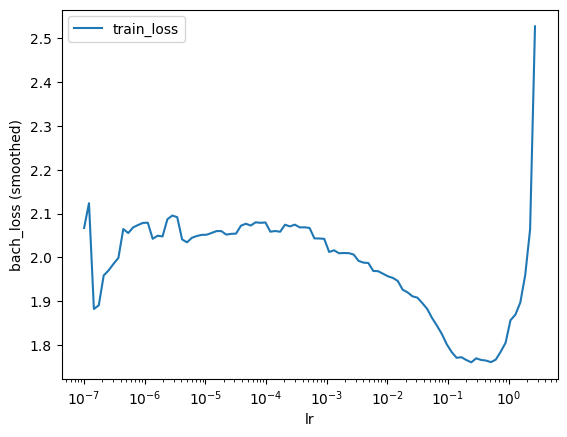

In [13]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=8)
_ = lr_finder.plot()

In [14]:
lr_finder.get_best_lr()

0.02420128264794396

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [15]:
model.optimizer.set_lr(0.01)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [16]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 1.9157,	val_loss: 2.0312
1:	[0s / 0s],		train_loss: 1.8102,	val_loss: 1.9793
2:	[0s / 0s],		train_loss: 1.7839,	val_loss: 1.8581
3:	[0s / 0s],		train_loss: 1.7972,	val_loss: 1.7036
4:	[0s / 0s],		train_loss: 1.5514,	val_loss: 1.5458
5:	[0s / 0s],		train_loss: 1.5497,	val_loss: 1.3932
6:	[0s / 0s],		train_loss: 1.4127,	val_loss: 1.2860
7:	[0s / 0s],		train_loss: 1.1041,	val_loss: 1.2159
8:	[0s / 0s],		train_loss: 1.2218,	val_loss: 1.1918
9:	[0s / 0s],		train_loss: 1.0787,	val_loss: 1.1990
10:	[0s / 0s],		train_loss: 1.0837,	val_loss: 1.2134
11:	[0s / 0s],		train_loss: 1.0733,	val_loss: 1.2169
12:	[0s / 0s],		train_loss: 1.0054,	val_loss: 1.1882
13:	[0s / 0s],		train_loss: 0.8791,	val_loss: 1.1755
14:	[0s / 0s],		train_loss: 1.2467,	val_loss: 1.1788
15:	[0s / 0s],		train_loss: 1.0193,	val_loss: 1.2010
16:	[0s / 0s],		train_loss: 0.9619,	val_loss: 1.2243
17:	[0s / 0s],		train_loss: 1.0873,	val_loss: 1.2492
18:	[0s / 0s],		train_loss: 1.0068,	val_loss: 1.2404
19:

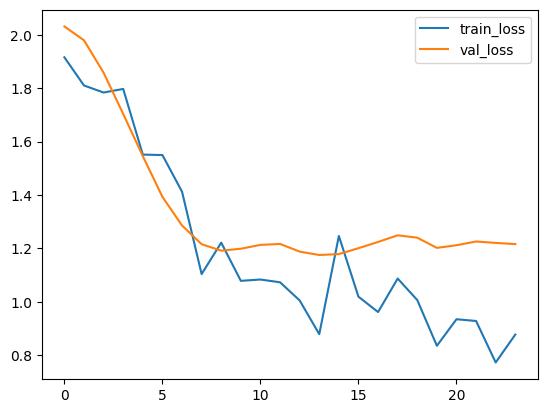

In [17]:
_ = log.plot()

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, we need to define at how many points we want to get the predictions.
The default (`model.sub = 1`) is just to use the interval knots, but by increasing the `model.sub` argument, we replace the knots with and equidistant number of points in each interval.
This is very similar to the interpolation of the discrete methods such as `LogisticHazard` and `PMF`.

In [18]:
surv = model.predict_surv_df(x_test)

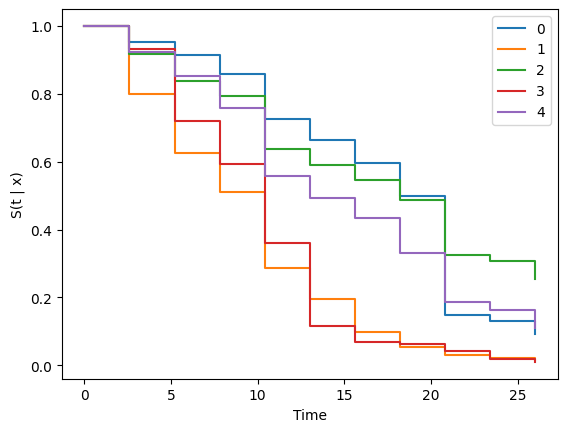

In [19]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [20]:
model.sub = 10

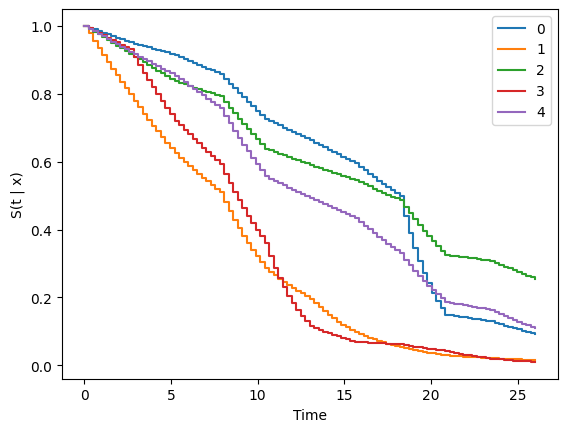

In [21]:
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

The `EvalSurv` class contains some useful evaluation criteria for time-to-event prediction.
We set `censor_surv = 'km'` to state that we want to use Kaplan-Meier for estimating the censoring distribution.


In [22]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

#### Concordance

We start with the event-time concordance by [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).

In [23]:
ev.concordance_td('antolini')

0.4895231213872832

#### Brier Score

We can plot the the [IPCW Brier score](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5) for a given set of times.
Here we just use 100 time-points between the min and max duration in the test set.
Note that the score becomes unstable for the highest times. It is therefore common to disregard the rightmost part of the graph.

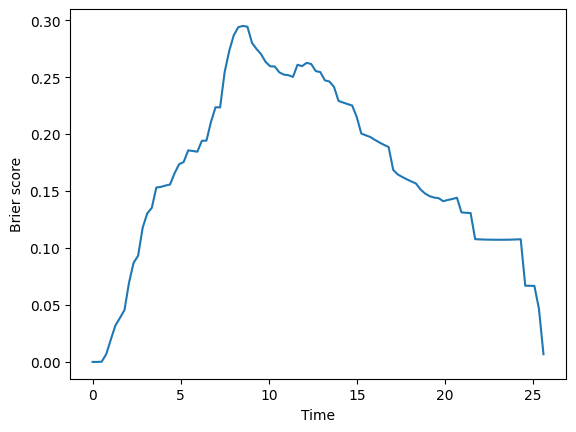

In [24]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

#### Negative binomial log-likelihood

In a similar manner, we can plot the the [IPCW negative binomial log-likelihood](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5).

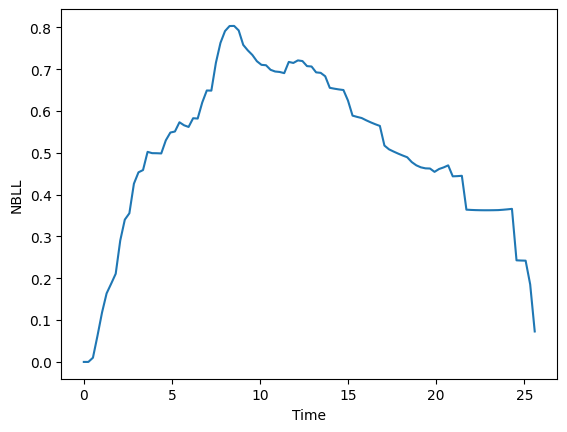

In [25]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

#### Integrated scores

The two time-dependent scores above can be integrated over time to produce a single score [Graf et al. 1999](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5). In practice this is done by numerical integration over a defined `time_grid`.

In [26]:
ev.integrated_brier_score(time_grid) 

0.16869082451621492

In [27]:
ev.integrated_nbll(time_grid) 

0.5093444694262138